In [366]:
import pandas as pd

df = pd.read_excel('./Data/online_retail.xlsx')
df.head(5)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [367]:
customer_df =df.groupby('CustomerID')['Country'].nunique().reset_index()
customer_df[customer_df['Country']>1]

,CustomerID,Country
20,12370.0,2
38,12394.0,2
56,12417.0,2
60,12422.0,2
67,12429.0,2
69,12431.0,2
90,12455.0,2
92,12457.0,2


In [368]:
cus_df = df.groupby('CustomerID')['Country'].max().reset_index()

In [369]:
import datetime as dt
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate']).dt.date
df = df[pd.notnull(df['CustomerID'])]
df = df[(df['Quantity']>0)]


df['Sales'] = df['Quantity'] * df['UnitPrice']
cols_of_interest = ['CustomerID', 'InvoiceDate', 'Sales']
df_i = df[cols_of_interest]


In [370]:
agg_df = df_i.groupby('InvoiceDate', as_index=False).count()
agg_df['InvoiceDate'] = pd.to_datetime(agg_df['InvoiceDate']).dt.date

In [371]:
agg_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 305 entries, 0 to 304
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   InvoiceDate  305 non-null    object
 1   CustomerID   305 non-null    int64 
 2   Sales        305 non-null    int64 
dtypes: int64(2), object(1)
memory usage: 7.3+ KB


In [372]:
agg_df.min()

InvoiceDate    2010-12-01
CustomerID            216
Sales                 216
dtype: object

In [373]:
agg_df.max()

InvoiceDate    2011-12-09
CustomerID           3423
Sales                3423
dtype: object

<Axes: xlabel='InvoiceDate'>

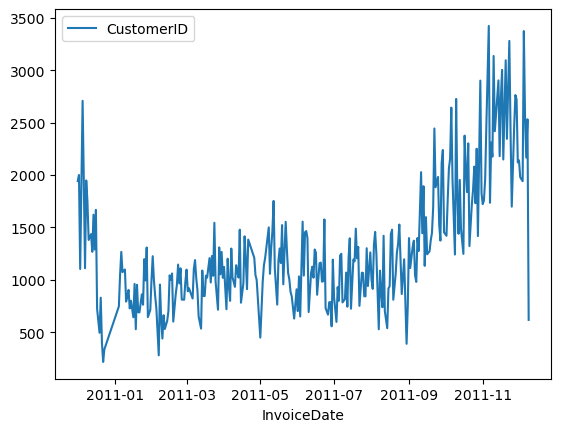

In [374]:
agg_df.plot(kind='line', x='InvoiceDate', y='CustomerID')

In [375]:
cutoff_date = pd.to_datetime("2011-06-01").date()
end_date = pd.to_datetime("2011-12-01").date()
train_df = df.loc[df['InvoiceDate']<=cutoff_date]

In [376]:
max_date = train_df.groupby('CustomerID', as_index=False).agg({'InvoiceDate':'max'})
max_date = max_date.rename(columns={"InvoiceDate": "MaxDate"}).set_index('CustomerID')
min_date = train_df.groupby('CustomerID', as_index=False).agg({'InvoiceDate':'min'})
min_date = min_date.rename(columns={"InvoiceDate": "MinDate"}).set_index('CustomerID')
freqeuncy = train_df.groupby('CustomerID', as_index=False).agg({'Sales':'count'})
freqeuncy = freqeuncy.rename(columns={"Sales": "Freqeuncy"}).set_index('CustomerID')
monetary = train_df.groupby('CustomerID', as_index=False).agg({'Sales':'sum'})
monetary = monetary.rename(columns={"Sales": "Monetary"}).set_index('CustomerID')


In [377]:
rmf_df = max_date.merge(min_date, left_index=True, right_index=True)\
    .merge(freqeuncy, left_index=True, right_index=True)\
        .merge(monetary, left_index=True, right_index=True).reset_index()

In [378]:
import numpy as np
rmf_df['CutoffDate'] = cutoff_date
rmf_df[['MinDate','MaxDate','CutoffDate']] = rmf_df[['MinDate','MaxDate', 'CutoffDate']].apply(pd.to_datetime)
#calculate difference between dates
rmf_df['Tenure'] = (rmf_df['CutoffDate'] - rmf_df['MinDate'])  / np.timedelta64(1, 'D')
rmf_df['Recency'] = (rmf_df['CutoffDate'] - rmf_df['MaxDate'])  / np.timedelta64(1, 'D')
rmf_df['Churn'] = rmf_df['Recency'].apply(lambda x: 1 if x >1 else 0)

In [379]:
from lifelines import KaplanMeierFitter
from lifelines.utils import median_survival_times
from lifelines.statistics import pairwise_logrank_test

In [380]:
kmf = KaplanMeierFitter()
 
T=rmf_df['Tenure']
C=rmf_df['Churn'].astype(float)
 
kmf.fit(T,C)

<lifelines.KaplanMeierFitter:"KM_estimate", fitted with 2725 total observations, 83 right-censored observations>

<Axes: title={'center': 'Kaplan-Meier Survival Curve'}, xlabel='timeline'>

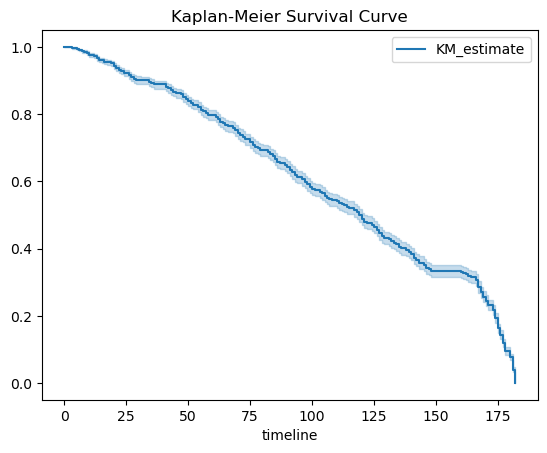

In [381]:
kmf.plot(title='Kaplan-Meier Survival Curve')

In [382]:
kmf.median_survival_time_

119.0

In [384]:
country_rmf_df =rmf_df.merge(cus_df, on=['CustomerID'])

In [385]:
country_rmf_df = country_rmf_df[country_rmf_df['Country'].isin(['United Kingdom','Germany','France'])].reset_index()
T=country_rmf_df['Tenure']
C=country_rmf_df['Churn'].astype(float)

In [386]:
import matplotlib.pyplot as plt
# Helper function for plotting Kaplan-Meier curves at the covariate level
def plot_km(col):
  ax = plt.subplot(111)
  for r in country_rmf_df[col].unique():
    ix = country_rmf_df[col] == r
    kmf.fit(T[ix], C[ix],label=r)
    kmf.plot(ax=ax)
    
# Helper function for printing out Log-rank test results
def print_logrank(col):
  log_rank = pairwise_logrank_test(country_rmf_df['Tenure'], country_rmf_df[col], country_rmf_df['Churn'])
  return log_rank.summary

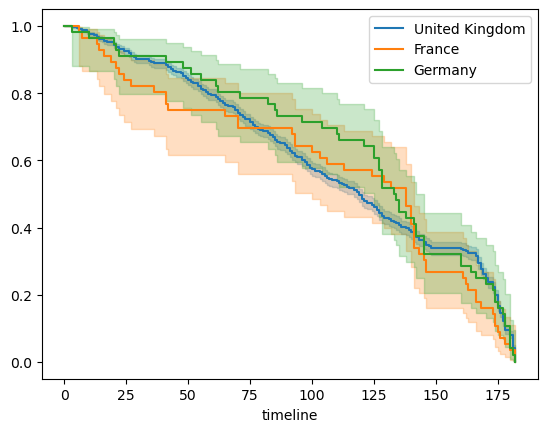

In [387]:
plot_km('Country')

In [388]:
print_logrank('Country')

test_statistic         p  -log2(p)
France  Germany               0.696160  0.404077  1.307298
        United Kingdom        1.099092  0.294466  1.763829
Germany United Kingdom        0.086193  0.769074  0.378806

In [389]:
kmf.median_survival_time_

133.0

In [390]:
def get_survival_probs(col,val):
  ix = country_rmf_df[col] == val
  return kmf.fit(T[ix],C[ix],label=val)  

In [391]:
rmf_df

,CustomerID,MaxDate,MinDate,Freqeuncy,Monetary,CutoffDate,Tenure,Recency,Churn
0,12346.0,2011-01-18,2011-01-18,1,77183.60,2011-06-01,134.0,134.0,1
1,12347.0,2011-04-07,2010-12-07,84,1823.43,2011-06-01,176.0,55.0,1
2,12348.0,2011-04-05,2010-12-16,28,1487.24,2011-06-01,167.0,57.0,1
3,12350.0,2011-02-02,2011-02-02,17,334.40,2011-06-01,119.0,119.0,1
4,12352.0,2011-03-22,2011-02-16,38,1561.81,2011-06-01,105.0,71.0,1
...,...,...,...,...,...,...,...,...,...
2720,18272.0,2011-04-28,2011-04-07,55,980.54,2011-06-01,55.0,34.0,1
2721,18273.0,2011-03-27,2011-03-27,1,51.00,2011-06-01,66.0,66.0,1
2722,18280.0,2011-03-07,2011-03-07,10,180.60,2011-06-01,86.0,86.0,1
2723,18283.0,2011-05-23,2011-01-06,232,535.05,2011-06-01,146.0,9.0,1


In [392]:
sp_internet_dsl = get_survival_probs('Country','United Kingdom')

In [393]:
pd.DataFrame(sp_internet_dsl.survival_function_at_times(range(0,10)))

,United Kingdom
0,1.000000
1,1.000000
2,1.000000
3,0.997965
4,0.997965
5,0.994709
6,0.992267
7,0.988602
8,0.986567
9,0.983309


# Cox

In [394]:
encode_cols = ['Country']
 
encoded_pd = pd.get_dummies(country_rmf_df,
               columns=encode_cols,
               prefix=encode_cols,
               drop_first=False)
 
encoded_pd.head()

,index,CustomerID,MaxDate,MinDate,Freqeuncy,Monetary,CutoffDate,Tenure,Recency,Churn,Country_France,Country_Germany,Country_United Kingdom
0,0,12346.0,2011-01-18,2011-01-18,1,77183.60,2011-06-01,134.0,134.0,1,0,0,1
1,31,12413.0,2011-04-17,2011-01-06,28,563.90,2011-06-01,146.0,45.0,1,1,0,0
2,38,12426.0,2011-05-29,2011-05-29,30,582.73,2011-06-01,3.0,3.0,1,0,1,0
3,39,12427.0,2010-12-03,2010-12-03,10,303.50,2011-06-01,180.0,180.0,1,0,1,0
4,46,12437.0,2011-05-25,2011-01-12,75,1975.09,2011-06-01,140.0,7.0,1,1,0,0


In [395]:
survival_pd = encoded_pd[['Churn','Tenure','Country_France',	'Country_Germany',	'Country_United Kingdom']]

In [396]:
survival_pd.loc[:,'Churn'] = survival_pd.loc[:,'Churn'].astype('float')
survival_pd.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2584 entries, 0 to 2583
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Churn                   2584 non-null   float64
 1   Tenure                  2584 non-null   float64
 2   Country_France          2584 non-null   uint8  
 3   Country_Germany         2584 non-null   uint8  
 4   Country_United Kingdom  2584 non-null   uint8  
dtypes: float64(2), uint8(3)
memory usage: 48.1 KB


/var/folders/tw/8wdkdtvs1fv8ftrnn4f5vt540000gn/T/ipykernel_15991/2656172636.py:1: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  survival_pd.loc[:,'Churn'] = survival_pd.loc[:,'Churn'].astype('float')


In [397]:
from lifelines.fitters.coxph_fitter import CoxPHFitter
from lifelines.statistics import proportional_hazard_test
from lifelines import KaplanMeierFitter

cph = CoxPHFitter(alpha=0.01,penalizer=0.01)
cph.fit(survival_pd, 'Tenure', 'Churn')

<lifelines.CoxPHFitter: fitted with 2584 total observations, 76 right-censored observations>

In [398]:
cph.print_summary()

<lifelines.CoxPHFitter: fitted with 2584 total observations, 76 right-censored observations>
             duration col = 'Tenure'
                event col = 'Churn'
                penalizer = 0.01
                 l1 ratio = 0.0
      baseline estimation = breslow
   number of observations = 2584
number of events observed = 2508
   partial log-likelihood = -17223.79
         time fit was run = 2023-04-30 03:48:22 UTC

---
                         coef  exp(coef)   se(coef)   coef lower 99%   coef upper 99%  exp(coef) lower 99%  exp(coef) upper 99%
covariate                                                                                                                      
Country_France           0.11       1.12       0.68            -1.65             1.88                 0.19                 6.53
Country_Germany         -0.06       0.94       0.68            -1.82             1.70                 0.16                 5.49
Country_United Kingdom  -0.03       0.97       0.68            -1.77             1.72                 0.17                 5.59

                         cmp to     z    p   -log2(p)
covariate                                            
Country_France             0.00  0.16 0.87       0.20
Country_Germany            0.00 -0.09 0.93       0.11
Country_United Kingdom     0.00 -0.04 0.97       0.04
---
Concordance = 0.50
Partial AIC = 34453.57
log-likelihood ratio test = 1.08 on 3 df
-log2(p) of ll-ratio test = 0.35

<Axes: xlabel='HR (99% CI)'>

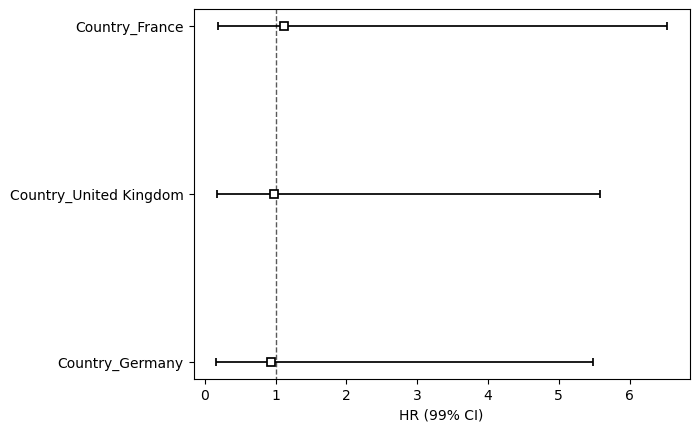

In [399]:
cph.plot(hazard_ratios=True)

In [400]:
cph.check_assumptions(survival_pd,p_value_threshold=0.05)

Proportional hazard assumption looks okay.


[]

In [401]:
cph.check_assumptions(survival_pd,p_value_threshold=0.05,show_plots=True)

Proportional hazard assumption looks okay.


[]

In [402]:
 widget_dict= {'Country_France':0,	'Country_Germany':0,	'Country_United Kingdom':0,' internal rate of return':0.10}
 df = pd.DataFrame.from_dict(widget_dict,orient='index').T

In [403]:
 df

,Country_France,Country_Germany,Country_United Kingdom,internal rate of return
0,0.0,0.0,0.0,0.1


In [410]:
cph.predict_survival_function(df)

,0
0.0,1.000000
1.0,1.000000
3.0,0.997612
5.0,0.994429
6.0,0.991644
...,...
177.0,0.121577
178.0,0.097994
180.0,0.083049
181.0,0.049725


In [404]:
# Construct dataframe with values from widgets

 
def get_payback_df():
  irr = df[' internal rate of return'].astype('float64')[0]/12
  cohort_df = pd.concat([pd.DataFrame([1.00]),round(cph.predict_survival_function(df),2)]).rename(columns={0:'Survival Probability'})
  cohort_df['Contract Month'] = cohort_df.index.astype('int')
  cohort_df['Monthly Profit for the Selected Plan'] = 30
  cohort_df['Avg Expected Monthly Profit'] = round(cohort_df['Survival Probability'] * cohort_df['Monthly Profit for the Selected Plan'],2)
  cohort_df['NPV of Avg Expected Monthly Profit'] = round(cohort_df['Avg Expected Monthly Profit'] / ((1+irr)**cohort_df['Contract Month']),2)
  cohort_df['Cumulative NPV'] = cohort_df['NPV of Avg Expected Monthly Profit'].cumsum()
  cohort_df['Contract Month'] = cohort_df['Contract Month'] + 1
  return cohort_df[['Contract Month','Survival Probability','Monthly Profit for the Selected Plan','Avg Expected Monthly Profit','NPV of Avg Expected Monthly Profit','Cumulative NPV']].set_index('Contract Month')


In [405]:
pd.options.display.max_rows = 25
get_payback_df()[0:25]

,Survival Probability,Monthly Profit for the Selected Plan,Avg Expected Monthly Profit,NPV of Avg Expected Monthly Profit,Cumulative NPV
Contract Month,,,,,
1,1.00,30,30.0,30.00,30.00
1,1.00,30,30.0,30.00,60.00
2,1.00,30,30.0,29.75,89.75
4,1.00,30,30.0,29.26,119.01
6,0.99,30,29.7,28.49,147.50
7,0.99,30,29.7,28.26,175.76
8,0.99,30,29.7,28.02,203.78
9,0.99,30,29.7,27.79,231.57
10,0.98,30,29.4,27.28,258.85


In [409]:
get_payback_df().tail()

,Survival Probability,Monthly Profit for the Selected Plan,Avg Expected Monthly Profit,NPV of Avg Expected Monthly Profit,Cumulative NPV
Contract Month,,,,,
178,0.12,30,3.6,0.83,1635.07
179,0.10,30,3.0,0.68,1635.75
181,0.08,30,2.4,0.54,1636.29
182,0.05,30,1.5,0.33,1636.62
183,0.02,30,0.6,0.13,1636.75


<Axes: xlabel='Contract Month', ylabel='Survival Probability'>

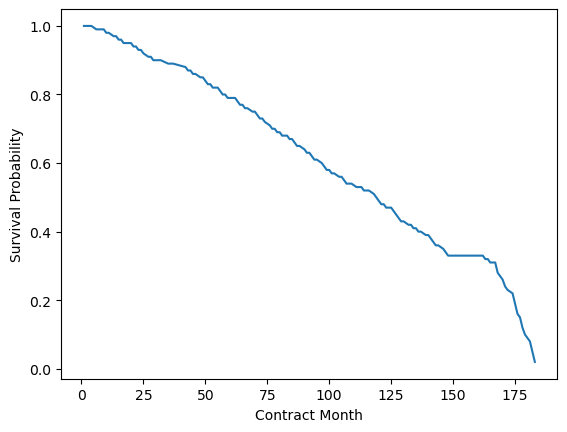

In [406]:
sns.lineplot(x=get_payback_df().index,y=get_payback_df()['Survival Probability'])

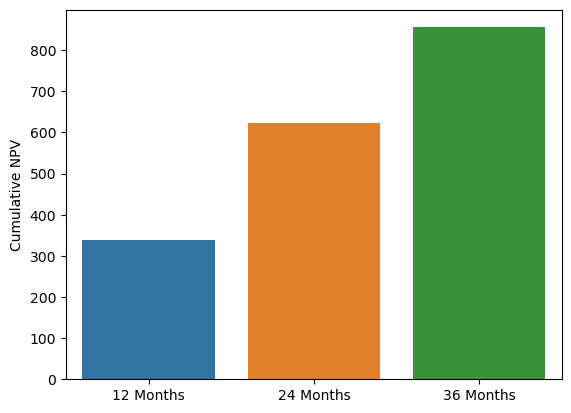

In [407]:
import seaborn as sns
ax = sns.barplot(x=['12 Months','24 Months','36 Months'],y=get_payback_df().iloc[[11,23,35],:]['Cumulative NPV'])

# BD/NBD

In [408]:
from lifetimes.plotting import *
from lifetimes.utils import *

data = summary_data_from_transaction_data(df, 'CustomerID', 'InvoiceDate', monetary_value_col='Sales', observation_period_end='2011-06-01')
data.head()

KeyError: "None of [Index(['CustomerID', 'InvoiceDate', 'Sales'], dtype='object')] are in the [columns]"

In [ ]:
from lifetimes import BetaGeoFitter
bgf = BetaGeoFitter(penalizer_coef=0.1)
bgf.fit(data['frequency'], data['recency'], data['T'])
print(bgf)

In [ ]:
from lifetimes.plotting import plot_frequency_recency_matrix
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(12,8))
plot_frequency_recency_matrix(bgf)

In [ ]:
from lifetimes.plotting import plot_probability_alive_matrix
fig = plt.figure(figsize=(12,8))
plot_probability_alive_matrix(bgf)

In [ ]:
t = 1
data['predicted_purchases'] = bgf.conditional_expected_number_of_purchases_up_to_time(t, data['frequency'], data['recency'], data['T'])
data.sort_values(by='predicted_purchases').tail(5)

In [ ]:
from lifetimes.plotting import plot_period_transactions
plot_period_transactions(bgf)

In [ ]:
from lifetimes.utils import calibration_and_holdout_data
summary_cal_holdout = calibration_and_holdout_data(df, 'CustomerID', 'InvoiceDate',
                                        calibration_period_end='2011-06-01',
                                        observation_period_end='2011-12-01' )   
print(summary_cal_holdout.head())

In [ ]:
from lifetimes.plotting import plot_calibration_purchases_vs_holdout_purchases
bgf.fit(summary_cal_holdout['frequency_cal'], summary_cal_holdout['recency_cal'], summary_cal_holdout['T_cal'])
plot_calibration_purchases_vs_holdout_purchases(bgf, summary_cal_holdout)

In [ ]:
t = 10
individual = data.loc[12347]
bgf.predict(t, individual['frequency'], individual['recency'], individual['T'])

In [ ]:
from lifetimes.plotting import plot_history_alive
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(12,8))
id = 14606
days_since_birth = 365
sp_trans = df.loc[df['CustomerID'] == id]
plot_history_alive(bgf, days_since_birth, sp_trans, 'InvoiceDate')

In [ ]:
fig = plt.figure(figsize=(12,8))
id = 14729
days_since_birth = 365
sp_trans = df.loc[df['CustomerID'] == id]
plot_history_alive(bgf, days_since_birth, sp_trans, 'InvoiceDate')

In [ ]:
returning_customers_summary = data[data['frequency']>0]
print(returning_customers_summary.head())
print(len(returning_customers_summary))

In [ ]:
from lifetimes import GammaGammaFitter
ggf = GammaGammaFitter(penalizer_coef = 0)
ggf.fit(returning_customers_summary['frequency'],
        returning_customers_summary['monetary_value'])
print(ggf)


In [ ]:
print(ggf.conditional_expected_average_profit(
        data['frequency'],
        data['monetary_value']
    ).head(10))